In [1]:
import os
import copy
from cheat.game import CheatGame
from cheat.bots import RandomBot, LLM_Player
import numpy as np
import asyncio
import logging
import tqdm
import json
from scipy.stats import binned_statistic_2d
import matplotlib.pyplot as plt

import pandas as pd

np.random.seed(11)
import random
random.seed(11)

plt.style.use(['evaluate.styles.default_style', 'evaluate.styles.font_garamond', 'evaluate.styles.font_size_12'])

## Bots-only

In [2]:
# Fill up with bots
def setup_game(num_players):
    game_players=[]
    for i in range(num_players):
        game_players.append(RandomBot(
            id=i,
            name=f'bot_{i}',
            avatar='🌼',
            p_call=np.random.rand(),
            p_lie=np.random.rand(),
            verbosity=0
        ))

    # Set up a new game. Each game maintains its own message queue
    game = CheatGame(
        players=game_players,
        experimental_mode=False,
        game_mode='single',
        message_queue = asyncio.Queue(), # Set up a new queue
        out_dir="game_data"
    )
    game.logger.setLevel(logging.INFO)
    game.player_logger.setLevel(logging.INFO)
    return game

In [3]:
winner_properties = []

In [4]:
game = setup_game(num_players=6)

In [5]:
# Play 10 rounds
n_rounds = 2
for i in tqdm.trange(n_rounds):
    await game.play_round(sleep_pause=0)
    winner_properties.append((game.players[game.winner].p_call, game.players[game.winner].p_lie))
    if i < n_rounds-1:
        game.new_round()
    else:
        game.game_over = True

  0%|          | 0/2 [00:00<?, ?it/s]15:57:21  GAME       INFO      [fde878e6]  Current player: bot_3 (id: 3, type: bot)
15:57:21  PLAYER     INFO      [fde878e6]  bot_3 plays 8♣, 10♥, 8♠ and declares Q.
15:57:21  GAME       INFO      [fde878e6]  Current player: bot_4 (id: 4, type: bot)
15:57:21  PLAYER     INFO      [fde878e6]  Successful call by bot_4.
15:57:21  PLAYER     INFO      [fde878e6]  bot_4 plays 8♦ and declares K.
15:57:21  GAME       INFO      [fde878e6]  Current player: bot_5 (id: 5, type: bot)
15:57:21  PLAYER     INFO      [fde878e6]  Successful call by bot_5.
15:57:21  PLAYER     INFO      [fde878e6]  bot_5 plays 4♥, 7♠, 10♦ and declares 5.
15:57:21  GAME       INFO      [fde878e6]  Current player: bot_0 (id: 0, type: bot)
15:57:21  PLAYER     INFO      [fde878e6]  bot_0 plays 5♣ and declares 5.
15:57:21  GAME       INFO      [fde878e6]  Current player: bot_1 (id: 1, type: bot)
15:57:21  PLAYER     INFO      [fde878e6]  Unsuccessful call by bot_1.
15:57:21  GAME      

In [ ]:
data = np.array(winner_properties)
x, y = data[:,0], data[:,1]
# Define bin edges
xbins = np.linspace(x.min(), x.max(), 10)   # 50 bins
ybins = np.linspace(y.min(), y.max(), 10)

# 2D counts
counts, _, _, _ = binned_statistic_2d(
    x, y, None, statistic='count', bins=[xbins, ybins]
)

plt.imshow(
    counts.T,
    origin='lower',
    extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]],
    aspect='auto'
)
plt.colorbar(label='count')
plt.xlabel('p_call')
plt.ylabel('p_lie')
plt.show()

## Mixed LLM-bot game

In [2]:
N_players = 4

system_prompt_template = "You are playing Cheat with {N_players} other players. You are Player {player_id}. Goal: get rid of all cards. On your turn: play 1-3 cards face down and declare a rank (Aces cannot be declared). You can bluff - cards don't need to match declaration. Options: 'Call' (challenge previous play), 'Play [cards]' (follow current rank), or 'Play [cards]; Declare rank' (start new rank when pile empty). Four-of-a-kind auto-discard. Win by emptying hand. FORMAT REQUIREMENTS: - Respond ONLY with: 'Call', 'Play [card1, card2]', or 'Play [cards]; Declare rank' - Use J/Q/K/A for face cards - Examples: 'Play [4♣, 4♦]; Declare 4', 'Play [A♠, K♥]', 'Play [2♥, J♣]; Declare J' - NO extra text: backend parsing depends on exact format."

In [3]:
# Fill up with bots
game_players=[]
for i in range(N_players):
    if i == 0:
        game_players.append(LLM_Player(
            id=i,
            name=f'DeepSeek',
            avatar='🤖',
            system_prompt = system_prompt_template.format(N_players=N_players-1,  player_id=i),
            kind='deepseek',
            model_kwargs=dict(model='deepseek-chat', stream=False)
        ))
    else:
        game_players.append(RandomBot(
            id=i,
            name=f'bot_{i}',
            avatar='🌼',
            p_call=np.random.rand(),
            p_lie=np.random.rand(),
            verbosity=0
        ))
    # if i == 0:
    #     game_players.append(LLM_Player(
    #         id=i,
    #         name=f'ChatGPT',
    #         avatar='🌼',
    #         init_prompt = dict(
    #         kind='open_ai',
    #         model='gpt-5-nano'
    #     ))

    # elif i == 2:
    #     game_players.append(LLM_Player(
    #         id=i,
    #         name=f'Google Gemini',
    #         avatar='🌼',
    #         init_prompt = input_prompt,
    #         kind='gemini',
    #         model='gemini-3-pro-preview'
    #     ))
# Set up a new game. Each game maintains its own message queue
game = CheatGame(
    players=game_players,
    experimental_mode=False,
    game_mode='single',
    message_queue = asyncio.Queue(), # Set up a new queue
    out_dir="game_data"
)

In [4]:
n_rounds = 4
for i in tqdm.trange(n_rounds):
    await game.play_round(sleep_pause=0)
    game.new_round()

  0%|          | 0/4 [00:00<?, ?it/s]19:36:44  GAME       INFO      [f5a430d4]  Current player: bot_3 (id: 3, type: bot)
19:36:44  PLAYER     INFO      [f5a430d4]  bot_3 plays 3♣, Q♦, 6♦ and declares Q.
19:36:44  GAME       INFO      [f5a430d4]  Current player: DeepSeek (id: 0, type: LLM)
19:36:46  PLAYER     INFO      [f5a430d4]  LLM response: Play [J♣]; Declare Q
19:36:46  PLAYER     INFO      [f5a430d4]  DeepSeek plays J♣ and declares Q.
19:36:46  GAME       INFO      [f5a430d4]  Current player: bot_1 (id: 1, type: bot)
19:36:46  PLAYER     INFO      [f5a430d4]  bot_1 plays Q♣ and declares Q.
19:36:46  GAME       INFO      [f5a430d4]  Current player: bot_2 (id: 2, type: bot)
19:36:46  PLAYER     INFO      [f5a430d4]  Unsuccessful call by bot_2.
19:36:46  PLAYER     INFO      [f5a430d4]  bot_2 discards 3.
19:36:46  GAME       INFO      [f5a430d4]  Current player: bot_3 (id: 3, type: bot)
19:36:46  PLAYER     INFO      [f5a430d4]  bot_3 plays 8♠ and declares K.
19:36:46  GAME       IN

In [13]:
# Reconstruct a DataFrame for each round
with open(f"{game.out_path}/game_history.jsonl", "r") as f:
    game_history = [json.loads(line) for line in f if line.strip()]

In [14]:
def deep_copy_row(df_row):
    """Create a deep copy of a DataFrame row with list columns"""
    row_dict = df_row.to_dict()
    for key, value in row_dict.items():
        if isinstance(value, list):
            row_dict[key] = value.copy()
    return pd.Series(row_dict)

In [15]:
from cheat.card import RANK_ORDER

In [16]:
game_data = pd.DataFrame(columns=['game_id', 'round', 'state', 'Pile', 'Discards'] + [f'Player {p.id}' for p in game.players])
for record in game_history:

    # New round: write initial state
    if record['type'] == 'new_round':
        # Extract data
        game_id = record['game_id']
        round_num = record['round']
        state = record['type']  # 'new_round'

        # Extract player hands from the nested data
        player_hands = record['data']['player_hands']

        # Create row data - fill player columns with their hand strings
        row_data = {
            'game_id': game_id,
            'round': round_num,
            'state': state,
            'Player': '',
            'Current rank': None,
            'Pile': [],  # Not in this record
            'Discards': []  # Not in this record
        }

        # Add player hand columns
        for player_key, hand in player_hands.items():
            # player_key is '0', '1', etc.
            # Convert hand list to string representation
            row_data[f'Player {player_key}'] = copy.deepcopy(hand) if hand else []

        # Fill missing player columns with empty string
        for i in range(4):  # Assuming 4 players
            col_name = f'Player {i}'
            if col_name not in row_data:
                row_data[col_name] = ''

        # Create DataFrame row and append
        row_df = pd.DataFrame([row_data])
        game_data = pd.concat([game_data, row_df], ignore_index=True)

    # Play: move played cards from Players hands to pile
    elif record['type'] == 'play':
        row_df = deep_copy_row(game_data.iloc[-1])
        row_df['state'] = 'play'
        row_df['Player'] = record['player_id']
        row_df['Current rank'] = record['data']['declared_rank']
        cards_played = record['data']['cards_played']
        for c in cards_played:
            row_df[f"Player {record['player_id']}"].remove(c)
            row_df["Pile"].append(c)
        game_data = pd.concat([game_data, pd.DataFrame(row_df).T], ignore_index=True, axis=0)

    # Call: move pile from Players who successfully called
    elif record['type'] == 'call':
        row_df = deep_copy_row(game_data.iloc[-1])
        row_df['state'] = 'call'
        row_df['Current rank'] = None
        row_df['Player'] = record['player_id']
        accused_id = record['data']['accused_id']
        if record['data']['was_lying']:
            add_to_player = f"Player {record['data']['accused_id']}"
        else:
            add_to_player = f"Player {record['player_id']}"
        row_df[add_to_player].extend(row_df['Pile'])
        row_df[add_to_player] = sorted(row_df[add_to_player], key=lambda c: RANK_ORDER[c[:-1]])
        row_df['Pile'] = []

        game_data = pd.concat([game_data, pd.DataFrame(row_df).T], ignore_index=True, axis=0)

    # Discards
    elif record['type'] == 'discard':
        row_df = deep_copy_row(game_data.iloc[-1])
        row_df['Player'] = record['player_id']
        row_df['state'] = 'discard'

        row_df['Discards'].extend([c for c in row_df[f"Player {record['player_id']}"] if c[:-1] in record['data']])
        row_df[f"Player {record['player_id']}"] = [c for c in row_df[f"Player {record['player_id']}"] if c[:-1] not in record['data']]
        game_data = pd.concat([game_data, pd.DataFrame(row_df).T], ignore_index=True, axis=0)

In [17]:
game_data[(game_data['Current rank'] == '8') & (game_data['round'] == 2)]

,game_id,round,state,Pile,Discards,Player 0,Player 1,Player 2,Player 3,Player,Current rank
53,f5a430d4,2,play,"[4♥, Q♣, 2♥]",[],"[3♦, 4♠, 4♣, 5♣, 5♦, 7♦, 8♦, 8♥, 9♥, 10♦, J♠, ...","[2♣, 4♦, 6♦, 7♠, 8♠, 9♣, J♣, J♦, Q♥, K♥, K♦]","[2♦, 2♠, 3♣, 3♥, 3♠, 5♠, 6♠, 6♥, 7♣, 8♣, 9♠, 1...","[5♥, 6♣, 7♥, 9♦, J♥, Q♠, K♠, A♥, A♣, A♠]",3,8
54,f5a430d4,2,play,"[4♥, Q♣, 2♥, 8♦, 8♥]",[],"[3♦, 4♠, 4♣, 5♣, 5♦, 7♦, 9♥, 10♦, J♠, Q♦, K♣]","[2♣, 4♦, 6♦, 7♠, 8♠, 9♣, J♣, J♦, Q♥, K♥, K♦]","[2♦, 2♠, 3♣, 3♥, 3♠, 5♠, 6♠, 6♥, 7♣, 8♣, 9♠, 1...","[5♥, 6♣, 7♥, 9♦, J♥, Q♠, K♠, A♥, A♣, A♠]",0,8
55,f5a430d4,2,play,"[4♥, Q♣, 2♥, 8♦, 8♥, 8♠]",[],"[3♦, 4♠, 4♣, 5♣, 5♦, 7♦, 9♥, 10♦, J♠, Q♦, K♣]","[2♣, 4♦, 6♦, 7♠, 9♣, J♣, J♦, Q♥, K♥, K♦]","[2♦, 2♠, 3♣, 3♥, 3♠, 5♠, 6♠, 6♥, 7♣, 8♣, 9♠, 1...","[5♥, 6♣, 7♥, 9♦, J♥, Q♠, K♠, A♥, A♣, A♠]",1,8
56,f5a430d4,2,play,"[4♥, Q♣, 2♥, 8♦, 8♥, 8♠, 6♥]",[],"[3♦, 4♠, 4♣, 5♣, 5♦, 7♦, 9♥, 10♦, J♠, Q♦, K♣]","[2♣, 4♦, 6♦, 7♠, 9♣, J♣, J♦, Q♥, K♥, K♦]","[2♦, 2♠, 3♣, 3♥, 3♠, 5♠, 6♠, 7♣, 8♣, 9♠, 10♠, ...","[5♥, 6♣, 7♥, 9♦, J♥, Q♠, K♠, A♥, A♣, A♠]",2,8
57,f5a430d4,2,play,"[4♥, Q♣, 2♥, 8♦, 8♥, 8♠, 6♥, A♣, Q♠]",[],"[3♦, 4♠, 4♣, 5♣, 5♦, 7♦, 9♥, 10♦, J♠, Q♦, K♣]","[2♣, 4♦, 6♦, 7♠, 9♣, J♣, J♦, Q♥, K♥, K♦]","[2♦, 2♠, 3♣, 3♥, 3♠, 5♠, 6♠, 7♣, 8♣, 9♠, 10♠, ...","[5♥, 6♣, 7♥, 9♦, J♥, K♠, A♥, A♠]",3,8
58,f5a430d4,2,play,"[4♥, Q♣, 2♥, 8♦, 8♥, 8♠, 6♥, A♣, Q♠, 4♠, 4♣]",[],"[3♦, 5♣, 5♦, 7♦, 9♥, 10♦, J♠, Q♦, K♣]","[2♣, 4♦, 6♦, 7♠, 9♣, J♣, J♦, Q♥, K♥, K♦]","[2♦, 2♠, 3♣, 3♥, 3♠, 5♠, 6♠, 7♣, 8♣, 9♠, 10♠, ...","[5♥, 6♣, 7♥, 9♦, J♥, K♠, A♥, A♠]",0,8
62,f5a430d4,2,play,[8♣],[],"[2♥, 3♦, 4♥, 4♠, 4♣, 5♣, 5♦, 6♥, 7♦, 8♦, 8♥, 8...","[2♣, 4♦, 6♦, 7♠, 9♣, J♣, J♦, Q♥, K♥, K♦]","[2♦, 2♠, 3♣, 3♥, 3♠, 5♠, 6♠, 7♣, 9♠, 10♠, 10♣,...","[5♥, 6♣, 7♥, 9♦, J♥, K♠, A♥, A♠]",2,8
64,f5a430d4,2,play,"[8♦, 8♥, 8♠]",[],"[2♥, 3♦, 4♥, 4♠, 4♣, 5♣, 5♦, 6♥, 7♦, 9♥, 10♦, ...","[2♣, 4♦, 6♦, 7♠, 9♣, J♣, J♦, Q♥, K♥, K♦]","[2♦, 2♠, 3♣, 3♥, 3♠, 5♠, 6♠, 7♣, 9♠, 10♠, 10♣,...","[5♥, 6♣, 7♥, 8♣, 9♦, J♥, K♠, A♥, A♠]",0,8
65,f5a430d4,2,play,"[8♦, 8♥, 8♠, 7♠]",[],"[2♥, 3♦, 4♥, 4♠, 4♣, 5♣, 5♦, 6♥, 7♦, 9♥, 10♦, ...","[2♣, 4♦, 6♦, 9♣, J♣, J♦, Q♥, K♥, K♦]","[2♦, 2♠, 3♣, 3♥, 3♠, 5♠, 6♠, 7♣, 9♠, 10♠, 10♣,...","[5♥, 6♣, 7♥, 8♣, 9♦, J♥, K♠, A♥, A♠]",1,8
66,f5a430d4,2,play,"[8♦, 8♥, 8♠, 7♠, 10♥]",[],"[2♥, 3♦, 4♥, 4♠, 4♣, 5♣, 5♦, 6♥, 7♦, 9♥, 10♦, ...","[2♣, 4♦, 6♦, 9♣, J♣, J♦, Q♥, K♥, K♦]","[2♦, 2♠, 3♣, 3♥, 3♠, 5♠, 6♠, 7♣, 9♠, 10♠, 10♣,...","[5♥, 6♣, 7♥, 8♣, 9♦, J♥, K♠, A♥, A♠]",2,8


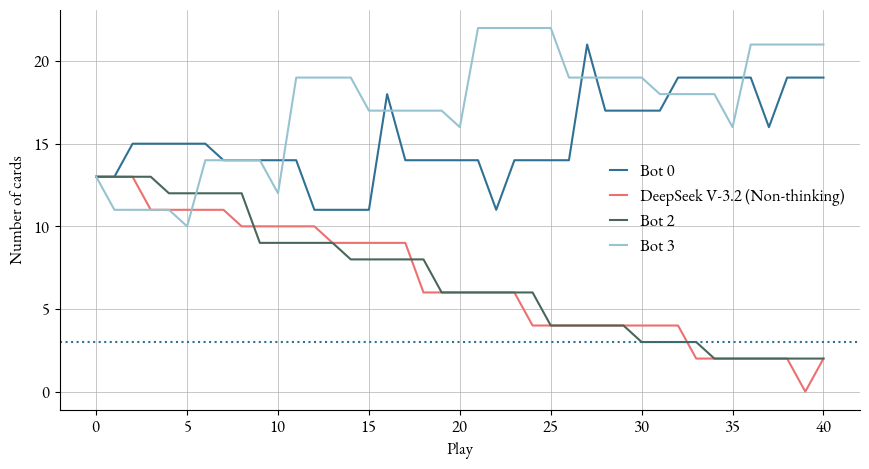

In [272]:
fig, ax = plt.subplots(figsize=(8, 4))
game_data[game_data['round']==1][['Player 0', 'Player 1', 'Player 2', 'Player 3']].map(len).rename({"Player 0": "Bot 0", "Player 1": "DeepSeek V-3.2 (Non-thinking)", "Player 2": "Bot 2", "Player 3": "Bot 3"}, axis=1).plot(ax=ax)
ax.set(ylabel='Number of cards', xlabel='Play')
ax.axhline(3, ls='dotted')

In [19]:
from cheat.bots.LLM import convert_LLM_response, is_valid_move
move = convert_LLM_response(game, "Play [J♠, J♦]; Declare J")
is_valid_move(move, game, game.players[0].hand)

(False, 'You can only play cards you currently hold.')